In [1]:
!pip install torch-summary -q

In [2]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union
from torchvision import models
from torchsummary import summary
from torch.autograd import Variable
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
import torch
import random
import numpy as np

# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [4]:
train = pd.read_csv('/kaggle/input/custom-mnist/train.csv')
val = pd.read_csv('/kaggle/input/custom-mnist/t10k.csv')
print(f"Train shape: {train.shape}")
print(f"T10k shape: {val.shape}")

Train shape: (60000, 785)
T10k shape: (10000, 785)


In [5]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomMNIST(Dataset):
    def __init__(self, csv_file=None, csv_df=None):
        if csv_file is not None:
            self.annotations = pd.read_csv(csv_file)
        else:
            self.annotations = csv_df
        self.image_label = np.asarray(self.annotations['label'])
        self.image_data = np.asarray(self.annotations.iloc[:,1:])

    def __len__(self):
        return len(self.image_data)
    
    def __getitem__(self, index):
        image = self.image_data[index].reshape(28,28)
        label = self.image_label[index]
        image = torch.tensor(image).unsqueeze(0).float()
        return (image, label)

In [6]:
train = CustomMNIST(csv_df=train)
val = CustomMNIST(csv_df=val)

In [7]:
train_dataloader = DataLoader(train,
                             batch_size = 100,
                             shuffle = True,
                             num_workers = 1)
val_dataloader = DataLoader(val,
                           batch_size = 100,
                           shuffle = True,
                           num_workers =1)

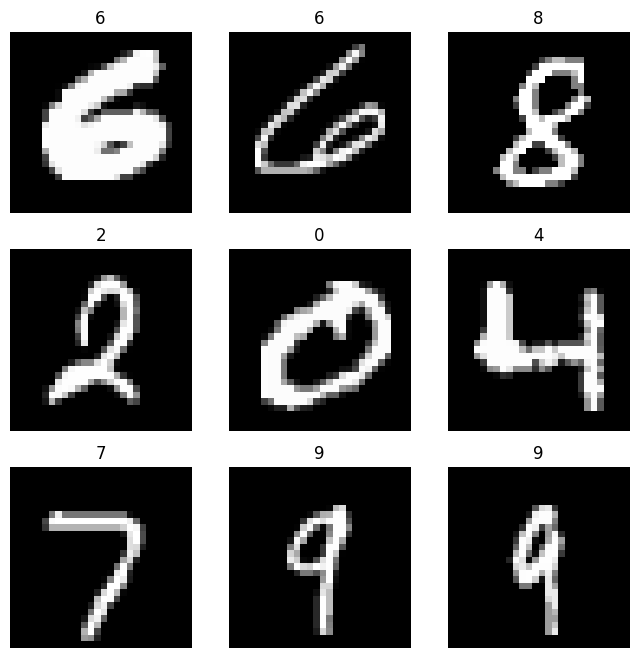

In [8]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train), size=(1,)).item()
    img, label = train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(label)
plt.show()

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
import torch
import torch.nn as nn


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 784
        self.conv1 = nn.Conv2d(
            image_channels, 784, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(784)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)



BATCH_SIZE = 4

model = ResNet50(img_channel=1, num_classes=10).to(device)
y = model((torch.randn(BATCH_SIZE, 1, 28, 28)).to(device)).to(device)
print(y.size())

torch.Size([4, 10])


In [11]:
def one_hot_encode(y):
        encoded = torch.zeros([10], dtype=torch.float64)
        encoded[y[0]] = 1.
        return encoded

Train Epoch: 1 [0/60000]	Loss: 2.758521
Train Epoch: 1 [10000/60000]	Loss: 0.617520
Train Epoch: 1 [20000/60000]	Loss: 0.380017
Train Epoch: 1 [30000/60000]	Loss: 0.277896
Train Epoch: 1 [40000/60000]	Loss: 0.153522
Train Epoch: 1 [50000/60000]	Loss: 0.132472

Test set: Average loss: 0.0014, Accuracy: 9524/10000 (95.2400%)

Train Epoch: 2 [0/60000]	Loss: 0.062856
Train Epoch: 2 [10000/60000]	Loss: 0.071450
Train Epoch: 2 [20000/60000]	Loss: 0.089624
Train Epoch: 2 [30000/60000]	Loss: 0.051485
Train Epoch: 2 [40000/60000]	Loss: 0.121109
Train Epoch: 2 [50000/60000]	Loss: 0.103066

Test set: Average loss: 0.0010, Accuracy: 9666/10000 (96.6600%)

Train Epoch: 3 [0/60000]	Loss: 0.136238
Train Epoch: 3 [10000/60000]	Loss: 0.040142
Train Epoch: 3 [20000/60000]	Loss: 0.127620
Train Epoch: 3 [30000/60000]	Loss: 0.063319
Train Epoch: 3 [40000/60000]	Loss: 0.031153
Train Epoch: 3 [50000/60000]	Loss: 0.159782

Test set: Average loss: 0.0009, Accuracy: 9714/10000 (97.1400%)

Train Epoch: 4 [0/6000

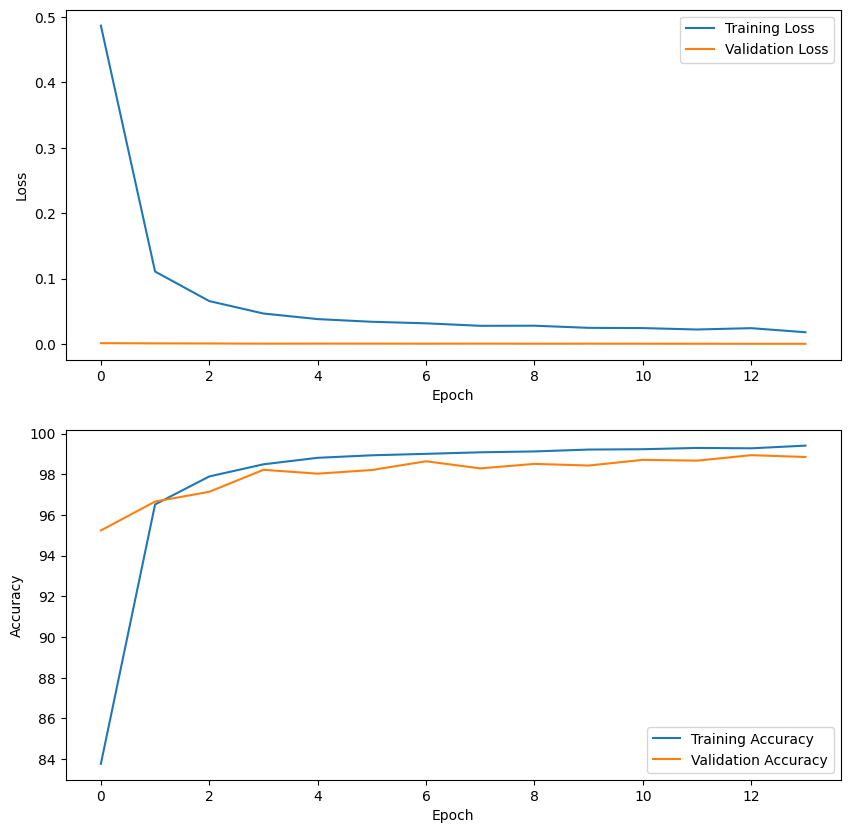

In [12]:
import random
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                loss.item()))
    train_losses.append(train_loss / len(train_dataloader))
    train_accs.append(100. * correct / total)

def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            target = target.long()
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(val_dataloader.dataset)
    val_losses.append(test_loss)
    val_accs.append(100. * correct / total)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(val_dataloader.dataset),
        100. * correct / len(val_dataloader.dataset)))

for epoch in range(1, 15):
    train(epoch)
    test()

# Plot the training and validation loss and accuracy over time
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(val_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(train_accs, label='Training Accuracy')
axs[1].plot(val_accs, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


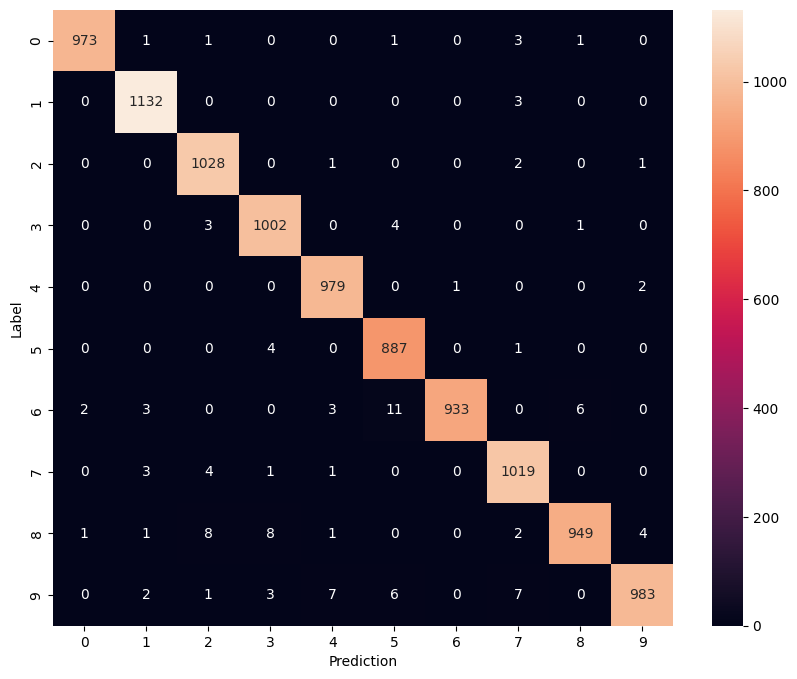

In [13]:
# import confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# set the model to evaluate
model.eval()

# get predictions for the test data
y_pred = []
y_true = []
for data, target in val_dataloader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    target = target.long()
    pred = output.argmax(dim=1, keepdim=True)
    y_pred.extend(pred.tolist())
    y_true.extend(target.tolist())

# generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [14]:
PATH = '/kaggle/working/model'

In [15]:
torch.save(model.state_dict(), PATH)

### 